In [1]:
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)
  
#read from google drive
data=pd.read_csv("https://drive.google.com/uc?export=download&id=1LU5be_H1TD2Pp1OmI202to3YyKo9AzFY")
  
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


## Describe and Groupby Are the Best places to Start`

In [3]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
data.groupby('country').size()

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [5]:
data.groupby('source').size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

## Lets Check Age

In [6]:
data.age.sort_values(ascending=False).unique()

array([123, 111,  79,  77,  73,  72,  70,  69,  68,  67,  66,  65,  64,
        63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,  51,
        50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,  38,
        37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,  25,
        24,  23,  22,  21,  20,  19,  18,  17], dtype=int64)

### Dropping Extra Age

In [7]:
data = data[data['age']<110]

## Country Conversion Rate

C:\Users\aratr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='country', ylabel='converted'>

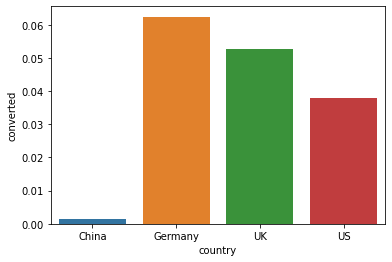

In [8]:
sns.barplot(pd.DataFrame(data.groupby(['country'])['converted'].mean()).reset_index()['country'],pd.DataFrame(data.groupby(['country'])['converted'].mean()).reset_index()['converted'])

# China converts at a lower conversion Rate

<AxesSubplot:xlabel='total_pages_visited'>

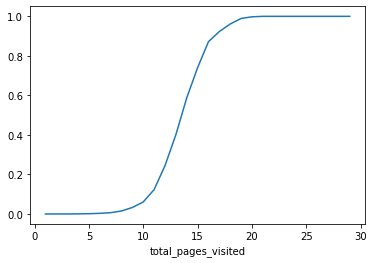

In [9]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()

# This makes Sense as higher the page visit, higher the conversion

## Creating Dummies

In [10]:
data_dummy = pd.get_dummies(data,drop_first=True)

## Building a Model

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [12]:
train, test = train_test_split(data_dummy,test_size=0.34)

In [13]:
rf =  RandomForestClassifier(n_estimators=100,max_features=3,oob_score=True)

In [14]:
rf.fit(train.drop('converted', axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9844458287411951 
 OOB Confusion Matrix 
         0     1
0  200898  1051
1    2195  4546


In [15]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)


Test accuracy is 0.9840197938758046 
 Test Set Confusion Matrix 
         0     1
0  103525   526
1    1192  2265


### Since the two scores is Similar, we can modify it a bit

In [16]:
test.shape

(107508, 9)

In [17]:
1112/107508

0.010343416303902965

<AxesSubplot:>

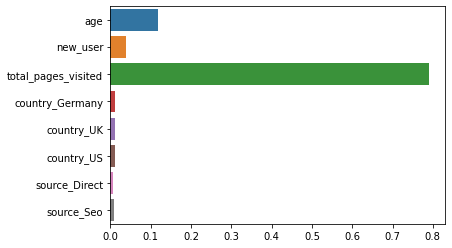

In [18]:
sns.barplot(y = train.drop('converted',axis=1).columns,x=rf.feature_importances_)

# Another Way

<AxesSubplot:>

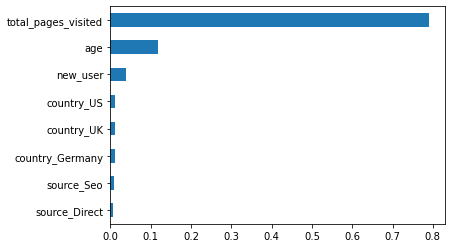

In [19]:
feature_imp = pd.Series(rf.feature_importances_,index = train.drop('converted',axis=1).columns)
feature_imp.sort_values().plot.barh()

## Total Pages Visited is Overpowering the Study

## So we remove it and Build new Models

In [20]:
rf = RandomForestClassifier(n_estimators=100,max_features=3,oob_score=True,class_weight={0:1,1:10})
rf.fit(train.drop(['converted','total_pages_visited'],axis=1),y=train['converted'])

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_features=3,
                       oob_score=True)

In [21]:
print('OOB Accuracy',rf.oob_score_)

OOB Accuracy 0.8895299247687958


In [22]:
feature_imp = pd.Series(rf.feature_importances_,index=train.drop(['converted','total_pages_visited'],axis=1).columns)

<AxesSubplot:>

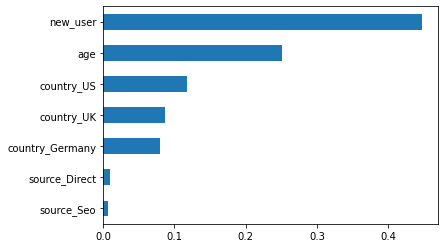

In [23]:
feature_imp.sort_values().plot.barh()

## SO New User is Very Important

# Lets check the 4 variables, through PDPs

In [24]:
from pdpbox import pdp, info_plots

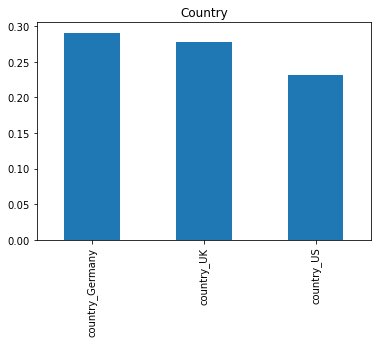

In [26]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

# Next Variable

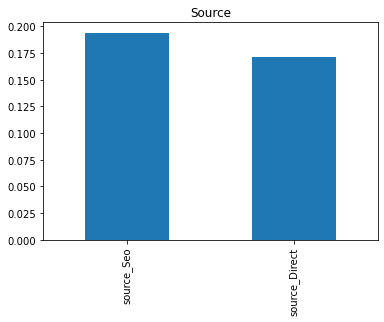

In [38]:
pdp_iso = pdp.pdp_isolate(model=rf,
                         dataset = train.drop(['converted','total_pages_visited'],axis=1),
                         model_features=list(train.drop(['converted','total_pages_visited'],axis=1)),
                         feature=['source_Direct','source_Seo'],
                         num_grid_points=50)
pdp_dataset=pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

# Next Variable

In [42]:
pdp_iso = pdp.pdp_isolate(model=rf,
                          dataset = train.drop(['converted','total_pages_visited'],axis=1),
                         model_features = list(train.drop(['converted','total_pages_visited'],axis=1)),
                          feature='new_user',
                          num_grid_points=50
                         )


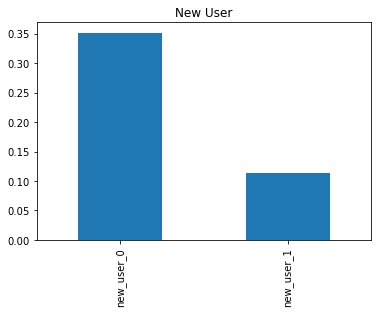

In [44]:
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()


# Age

In [45]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

NameError: name 'pandas' is not defined